In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import HTML, display
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from tqdm.notebook import tqdm

# np.random.seed(373)

WINE_DATASET = dict(
    url='https://www.openml.org/data/get_csv/3624/dataset_191_wine.arff',
    class_column_name='class'
)


In [2]:
# noinspection PyTypeChecker
def show_dataframe(df: pd.DataFrame):
    display(HTML(df.to_html()))


In [3]:
def dataset(dataset_meta, verbose=False):
    df = pd.read_csv(dataset_meta['url'])
    if verbose:
        show_dataframe(df)
    X = df[df.columns.difference([dataset_meta['class_column_name']])]
    y, unique = pd.factorize(df[dataset_meta['class_column_name']])

    X = (X - X.min()) / (X.max() - X.min())
    return X.to_numpy(), y, len(unique)


def get_bounds_idx(X_pca):
    xx, yy = X_pca.T
    x_min = xx.argmin()
    y_min = yy.argmin()
    y_max = yy.argmax()
    return list(map(int, [x_min, y_min, y_max]))


def transfer_markers(y_true, y_pred, X_pca):
    if len(np.unique(y_pred)) == len(np.unique(y_true)):
        pred_to_real = {}

        for i in get_bounds_idx(X_pca):
            pred_to_real[y_pred[i]] = y_true[i]

        if len(set(pred_to_real.values())) != len(np.unique(y_true)):
            print('Couldn\'t transfer labels', pred_to_real)
            return y_pred
        for pred_c, real_c in pred_to_real.items():
            y_pred[y_pred == pred_c] = -(real_c + 1)

        y_pred *= -1
        y_pred -= 1
        return y_pred
    return y_pred


def draw_plot(X_pca, classes, title='Clusters'):
    colours = ["m", "y", "k", "w"]
    xx, yy = X_pca.T
    plt.figure(figsize=(10, 10))

    for c in np.unique(classes):
        t = classes == c
        plt.scatter(xx[t], yy[t], color=colours[c], label=f'Class {c}')

    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title(title)
    plt.show()


In [4]:

def distance(x1, x2):
    return np.linalg.norm(x1 - x2)


class KMeans:
    def __init__(self, clusters, epochs_max=200):
        self.clusters = clusters
        self.epochs_max = epochs_max
        self.centroids = None

    def best_cluster(self, point):
        return int(np.argmin(list(map(partial(distance, x2=point), self.centroids))))

    def fit(self, X):
        self.centroids = [X[np.random.randint(len(X))]]
        for _ in range(self.clusters - 1):
            distances = np.apply_along_axis(
                lambda p: distance(p, self.centroids[self.best_cluster(p)]),
                1,
                X
            )

            bound_sum = np.random.random() * distances.sum()
            i = 0
            sm = distances[i]

            while sm < bound_sum:
                i += 1
                sm += distances[i]

            self.centroids.append(X[i])

        for _ in range(self.epochs_max):
            clusters = [[] for _ in range(self.clusters)]
            for point in X:
                cluster = self.best_cluster(point)
                clusters[cluster].append(point)

            new_centroids = [np.mean(clusters[i], axis=0) for i in range(self.clusters)]

            if np.allclose(new_centroids, self.centroids, rtol=1e-7):
                break

            self.centroids = new_centroids

    def predict(self, X):
        return np.apply_along_axis(self.best_cluster, 1, X)


In [5]:

def dunn_score(X, y):
    classes = len(np.unique(y))

    max_dist = -np.inf
    for i in range(classes):
        points = X[y == i]
        for j, p1 in enumerate(points):
            for p2 in points[j:]:
                max_dist = max(max_dist, distance(p1, p2))

    min_dist = np.inf  # outer
    for i, c1 in enumerate(y):
        for j, c2 in enumerate(y):
            if c1 != c2:
                min_dist = min(min_dist, distance(X[i], X[j]))

    return min_dist / max_dist


def scores(X, y, X_pca, max_clusters=20):
    metrics = dict(
        jaccard=lambda _y_pred: jaccard_score(y_true=y, y_pred=_y_pred, average='macro'),
        dunn=lambda _y_pred: dunn_score(X, _y_pred)
    )

    metered_clusters = list(range(2, max_clusters + 1))

    metrics_result = {}

    for name in metrics.keys():
        metrics_result[name] = []

    for clusters in tqdm(metered_clusters):
        kMeans = KMeans(clusters=clusters)

        kMeans.fit(X)
        y_pred = kMeans.predict(X)

        y_pred = transfer_markers(y, y_pred, X_pca)

        for name, func in metrics.items():
            metrics_result[name].append(func(y_pred))

    plt.figure(figsize=(10, 10))
    plt.title('Metrics')

    for name, yy in metrics_result.items():
        max_metric = int(np.argmax(yy))
        mx, my = metered_clusters[max_metric], yy[max_metric]
        lbl = '{}, max {:.2f} when {} clusters'.format(name, my, mx)
        plt.plot(metered_clusters, yy, label=lbl)

    plt.legend()
    plt.show()


In [6]:
def process(dataset_meta, verbose_level=0):
    X, y, classes_cnt = dataset(dataset_meta, verbose_level >= 2)

    if verbose_level >= 1:
        print(f"Got {len(y)} samples with {classes_cnt} classes. Features count: {X.shape[1]}")

    X_pca = PCA(n_components=2).fit_transform(X)
    draw_plot(X_pca, y, title='Real labels')

    kMeans = KMeans(classes_cnt)
    kMeans.fit(X)
    pred = kMeans.predict(X)
    pred = transfer_markers(y, pred, X_pca)

    draw_plot(X_pca, pred, title='K-Means labels')

    scores(X, y, X_pca, max_clusters=10)


Got 178 samples with 3 classes. Features count: 13


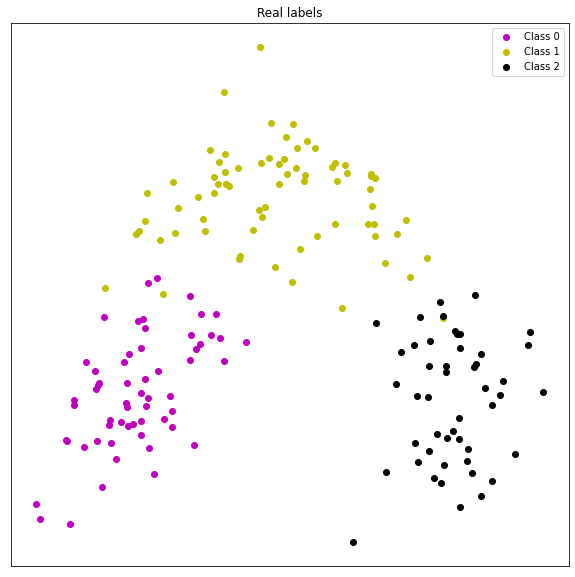

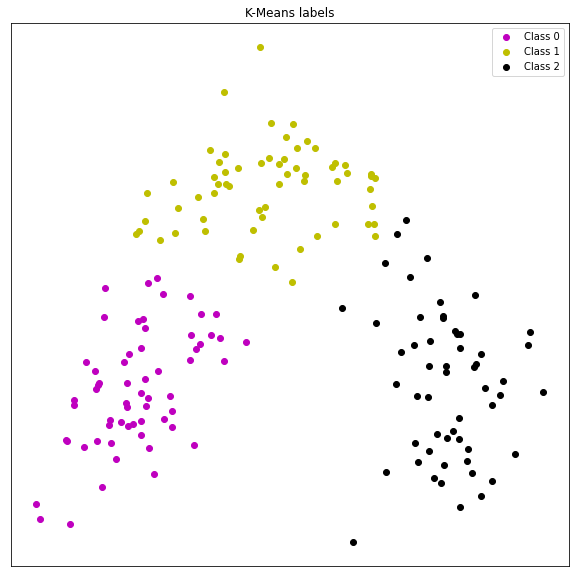

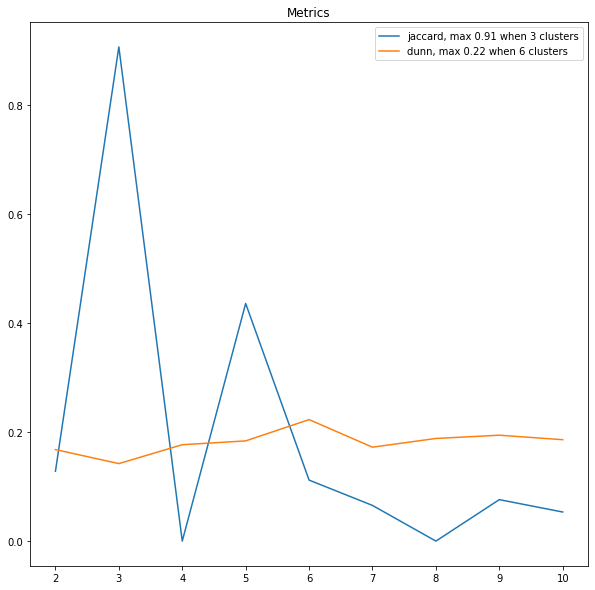

In [7]:
process(WINE_DATASET, verbose_level=1)
